# Import Data

In [3]:
import datetime as dt
from pathlib import Path
from pytz import timezone

import pandas as pd
import numpy as np
import os
import glob
import geopandas as gpd
from shapely import geometry, ops
import matplotlib.pyplot as plt
from matplotlib import pyplot
import plotly.graph_objects as go
from h3 import h3
import leafmap.kepler as leafmap
import h3
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import shapely
from shapely.ops import unary_union
from shapely.geometry import mapping, Polygon

import matplotlib.pyplot as plt
from libpysal.weights.contiguity import Queen
from libpysal import examples
import numpy as np
import pandas as pd
import geopandas as gpd
import os
import splot

In [4]:
df = pd.read_csv("/Users/yarongchen/Documents/UI_PhD/2_Spring_2022/geo_programming_final_project/Geo_Programming_Project/Data/2019/gdf_start_7.csv")
df = df.drop("geometry", axis=1)
df.head(5)

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,...,end_lng,member_casual,month,year,dayofweek,dayofmonth,duration_minutes,h3_index,lat,lng
0,BD0A6FF6FFF9B921,electric_bike,2020-11-01 13:36:00,2020-11-01 13:45:40,Dearborn St & Erie St,110.0,St. Clair St & Erie St,211.0,41.894177,-87.629127,...,-87.623379,casual,11,2020,6,1,9.666667,872664c1effffff,41.895400,-87.626394
1,96A7A7A4BDE4F82D,electric_bike,2020-11-01 10:03:26,2020-11-01 10:14:45,Franklin St & Illinois St,672.0,Noble St & Milwaukee Ave,29.0,41.890959,-87.635343,...,-87.662480,casual,11,2020,6,1,11.316667,872664cadffffff,41.891024,-87.655950
2,C61526D06582BDC5,electric_bike,2020-11-01 00:34:05,2020-11-01 01:03:06,Lake Shore Dr & Monroe St,76.0,Federal St & Polk St,41.0,41.880983,-87.616754,...,-87.629550,casual,11,2020,6,1,29.016667,872664c1affffff,41.874988,-87.635029
3,E533E89C32080B9E,electric_bike,2020-11-01 00:45:16,2020-11-01 00:54:31,Leavitt St & Chicago Ave,659.0,Stave St & Armitage Ave,185.0,41.895499,-87.682013,...,-87.691392,casual,11,2020,6,1,9.250000,872664ca1ffffff,41.923092,-87.697834
4,1C9F4EF18C168C60,electric_bike,2020-11-01 15:43:25,2020-11-01 16:16:52,Buckingham Fountain,2.0,Buckingham Fountain,2.0,41.876497,-87.620358,...,-87.620338,casual,11,2020,6,1,33.450000,872664c1affffff,41.874988,-87.635029


In [5]:
df = df[df['lat'] <= 42.1]
df = df[df['year'] == 2020]
df.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,...,end_lng,member_casual,month,year,dayofweek,dayofmonth,duration_minutes,h3_index,lat,lng
0,BD0A6FF6FFF9B921,electric_bike,2020-11-01 13:36:00,2020-11-01 13:45:40,Dearborn St & Erie St,110.0,St. Clair St & Erie St,211.0,41.894177,-87.629127,...,-87.623379,casual,11,2020,6,1,9.666667,872664c1effffff,41.895400,-87.626394
1,96A7A7A4BDE4F82D,electric_bike,2020-11-01 10:03:26,2020-11-01 10:14:45,Franklin St & Illinois St,672.0,Noble St & Milwaukee Ave,29.0,41.890959,-87.635343,...,-87.662480,casual,11,2020,6,1,11.316667,872664cadffffff,41.891024,-87.655950
2,C61526D06582BDC5,electric_bike,2020-11-01 00:34:05,2020-11-01 01:03:06,Lake Shore Dr & Monroe St,76.0,Federal St & Polk St,41.0,41.880983,-87.616754,...,-87.629550,casual,11,2020,6,1,29.016667,872664c1affffff,41.874988,-87.635029
3,E533E89C32080B9E,electric_bike,2020-11-01 00:45:16,2020-11-01 00:54:31,Leavitt St & Chicago Ave,659.0,Stave St & Armitage Ave,185.0,41.895499,-87.682013,...,-87.691392,casual,11,2020,6,1,9.250000,872664ca1ffffff,41.923092,-87.697834
4,1C9F4EF18C168C60,electric_bike,2020-11-01 15:43:25,2020-11-01 16:16:52,Buckingham Fountain,2.0,Buckingham Fountain,2.0,41.876497,-87.620358,...,-87.620338,casual,11,2020,6,1,33.450000,872664c1affffff,41.874988,-87.635029


In [6]:
df_duration = df[['h3_index', 'duration_minutes']]
df_duration = df_duration.groupby('h3_index').median()
df_duration = df_duration[['duration_minutes']].reset_index()
df_duration.head(5)

,h3_index,duration_minutes
0,872664191ffffff,26.600000
1,872664193ffffff,18.225000
2,872664195ffffff,24.066667
3,872664196ffffff,33.366667
4,87266419effffff,58.666667


In [7]:
# Create hexagon geometry and GeoDataFrame
df_duration['geometry'] = [Polygon(h3.h3_to_geo_boundary(x, geo_json=True)) for x in df_duration["h3_index"]]
df_duration = gpd.GeoDataFrame(df_duration)
df_duration.head(5)

,h3_index,duration_minutes,geometry
0,872664191ffffff,26.600000,"POLYGON ((-87.53629 41.67300, -87.54898 41.664..."
1,872664193ffffff,18.225000,"POLYGON ((-87.56572 41.66867, -87.57840 41.660..."
2,872664195ffffff,24.066667,"POLYGON ((-87.52765 41.69336, -87.54035 41.685..."
3,872664196ffffff,33.366667,"POLYGON ((-87.57791 41.70505, -87.59060 41.696..."
4,87266419effffff,58.666667,"POLYGON ((-87.54493 41.65265, -87.55761 41.644..."


In [8]:
df_duration = df_duration.rename(columns={"duration_minutes": "median_duration_minutes"})
df_duration.columns

Index(['h3_index', 'median_duration_minutes', 'geometry'], dtype='object')

In [9]:
df_duration.shape

(95, 3)

In [10]:
df_duration

,h3_index,median_duration_minutes,geometry
0,872664191ffffff,26.600000,"POLYGON ((-87.53629 41.67300, -87.54898 41.664..."
1,872664193ffffff,18.225000,"POLYGON ((-87.56572 41.66867, -87.57840 41.660..."
2,872664195ffffff,24.066667,"POLYGON ((-87.52765 41.69336, -87.54035 41.685..."
3,872664196ffffff,33.366667,"POLYGON ((-87.57791 41.70505, -87.59060 41.696..."
4,87266419effffff,58.666667,"POLYGON ((-87.54493 41.65265, -87.55761 41.644..."
...,...,...,...
90,872664d8dffffff,26.483333,"POLYGON ((-87.64646 42.00095, -87.65922 41.992..."
91,872664d8effffff,24.133333,"POLYGON ((-87.69707 42.01260, -87.70982 42.004..."
92,872664da3ffffff,25.183333,"POLYGON ((-87.67115 42.07397, -87.68392 42.065..."
93,872664daaffffff,17.916667,"POLYGON ((-87.65880 42.03745, -87.67156 42.029..."


# Median Time Duration Spatial Plot

<AxesSubplot:>

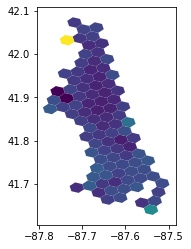

In [11]:
df_duration.plot(column='median_duration_minutes')

<AxesSubplot:>

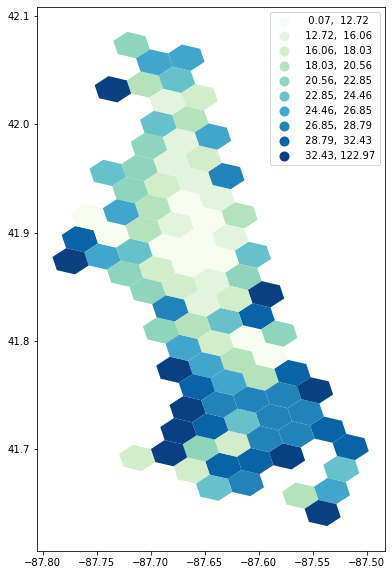

In [12]:
fig, ax = plt.subplots(figsize=(12,10), subplot_kw={'aspect':'equal'})
df_duration.plot(column='median_duration_minutes', scheme='Quantiles', k=10, cmap='GnBu', legend=True, ax=ax)
#ax.set_xlim(150000, 160000)
#ax.set_ylim(208000, 215000)


# Spatial Autocorrelation

### Spatial Similarity

In [13]:
import libpysal as lps
f = df_duration
wq =  lps.weights.Queen.from_dataframe(df_duration)
wq.transform = 'r'

### Attribute Similarity
So the spatial weight between neighborhoods  and  indicates if the two are neighbors (i.e., geographically similar). What we also need is a measure of attribute similarity to pair up with this concept of spatial similarity. The spatial lag is a derived variable that accomplishes this for us.

In [14]:
y = df_duration['median_duration_minutes']
ylag = lps.weights.lag_spatial(wq, y)
ylag

array([33.65277778, 42.63333333, 27.8875    , 28.08888889, 22.4125    ,
       28.44722222, 26.70416667, 22.50972222, 26.95277778, 27.03958333,
       24.73888889, 27.14583333, 27.07333333, 27.49166667, 35.75      ,
       22.14583333, 17.00333333, 13.92777778, 15.21111111, 14.58055556,
       14.93333333, 17.22777778, 15.56666667, 16.03888889, 23.18      ,
       15.74666667, 15.10625   , 22.31666667, 27.10416667, 18.23333333,
       20.62916667, 21.95625   , 20.74166667, 21.13333333, 18.35555556,
       11.96      , 19.69666667, 16.41666667, 21.05      , 16.26111111,
       14.11944444, 15.97361111, 18.43055556, 14.35555556, 12.83055556,
       15.84722222, 18.64861111, 24.28333333, 25.35694444, 24.9875    ,
       20.83888889, 20.72333333, 20.77638889, 27.35694444, 29.555     ,
       26.80694444, 26.72083333, 28.2875    , 29.57      , 26.07222222,
       26.65      , 24.28333333, 23.44666667, 30.96041667, 26.625     ,
       31.04375   , 29.34666667, 29.21111111, 23.99666667, 17.58

In [15]:
import mapclassify as mc
ylagq5 = mc.Quantiles(ylag, k=10)

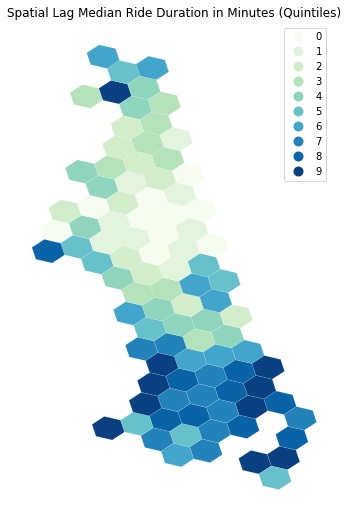

In [16]:
f, ax = plt.subplots(1, figsize=(9, 9))
df_duration.assign(cl=ylagq5.yb).plot(column='cl', categorical=True, \
        k=10, cmap='GnBu', linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("Spatial Lag Median Ride Duration in Minutes (Quintiles)")

plt.show()


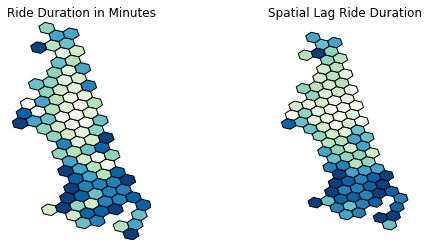

In [17]:
df_duration['lag_median_duration_minutes'] = ylag
f,ax = plt.subplots(1,2,figsize=(2.16*4,4))
df_duration.plot(column='median_duration_minutes', ax=ax[0], edgecolor='k',
        scheme="quantiles",  k=10, cmap='GnBu')
ax[0].axis(df_duration.total_bounds[np.asarray([0,2,1,3])])
ax[0].set_title("Ride Duration in Minutes")
df_duration.plot(column='lag_median_duration_minutes', ax=ax[1], edgecolor='k',
        scheme='quantiles', cmap='GnBu', k=10)
# ax[1].axis(df_duration.median_duration_minutes[np.asarray([0,2,1,3])])
ax[1].set_title("Spatial Lag Ride Duration")
ax[0].axis('off')
ax[1].axis('off')
plt.show()


### Global Spatial Autocorrelation

Binary spatial autocorrelation - high or low

In [18]:
y = df_duration['median_duration_minutes']
y.median()

22.849999999999998

In [19]:
yb = y > y.median()
sum(yb)

47

In [20]:
yb = y > y.median()
labels = ["0 Low", "1 High"]
yb = [labels[i] for i in 1*yb]
df_duration['yb'] = yb

<AxesSubplot:>

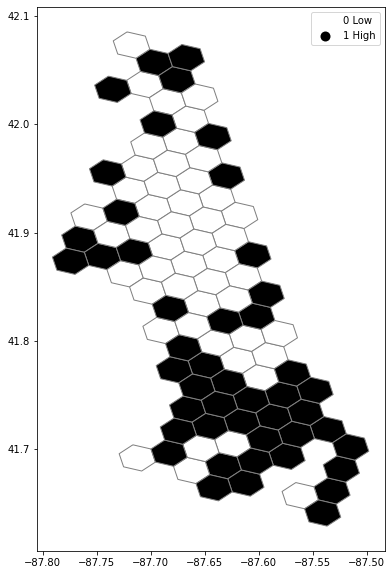

In [21]:
fig, ax = plt.subplots(figsize=(12,10), subplot_kw={'aspect':'equal'})
df_duration.plot(column='yb', cmap='binary', edgecolor='grey', legend=True, ax=ax)

In [22]:
import esda
np.random.seed(12345)
mi = esda.moran.Moran(y, wq)
mi.I

0.08907412122161822

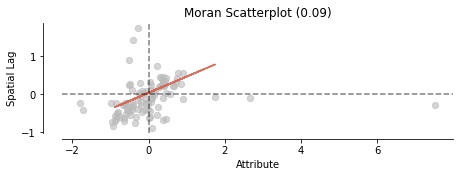

In [24]:
from splot.esda import moran_scatterplot
from esda.moran import Moran

w = Queen.from_dataframe(df_duration)
moran = Moran(y, w)
fig, ax = moran_scatterplot(moran, aspect_equal=True)
plt.show()

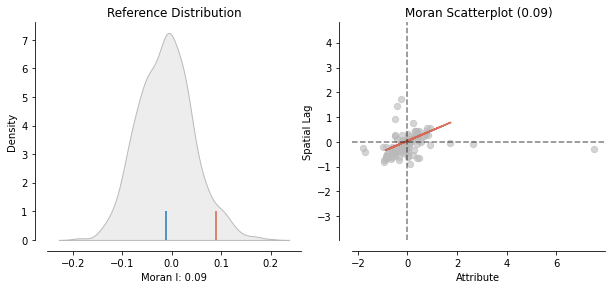

In [25]:
from splot.esda import plot_moran

plot_moran(moran, zstandard=True, figsize=(10,4))
plt.show()

In [26]:
moran.p_sim

0.048

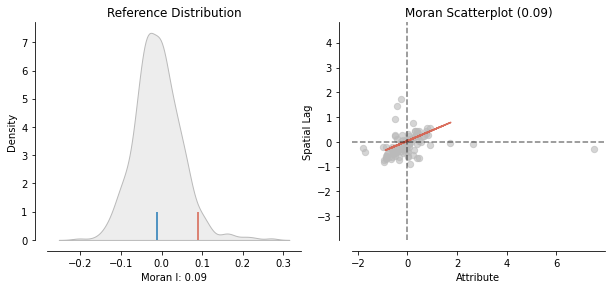

In [27]:
from splot.esda import plot_moran

plot_moran(mi, zstandard=True, figsize=(10,4))
plt.show()

In [28]:
w.histogram

[(1, 3), (2, 7), (3, 16), (4, 12), (5, 19), (6, 38)]

### Local Autocorrelation: Hot Spots, Cold Spots, and Spatial Outliers

In [29]:
np.random.seed(12345)
import esda
wq.transform = 'r'
lag_p = lps.weights.lag_spatial(wq, df_duration['median_duration_minutes'])

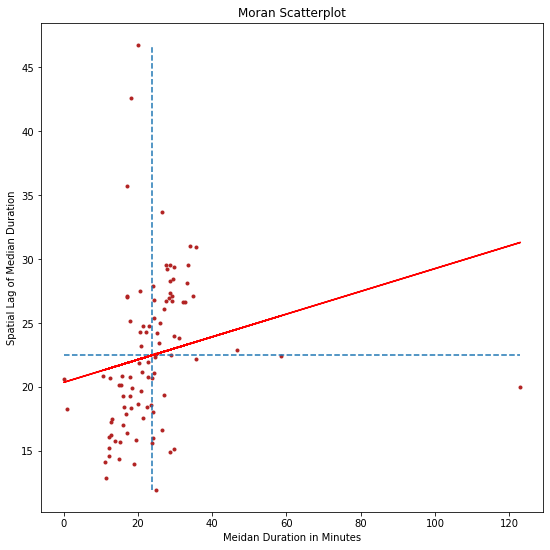

In [30]:
p = df_duration['median_duration_minutes']
b, a = np.polyfit(p, lag_p, 1)
f, ax = plt.subplots(1, figsize=(9, 9))

plt.plot(p, lag_p, '.', color='firebrick')

 # dashed vert at mean of the price
plt.vlines(p.mean(), lag_p.min(), lag_p.max(), linestyle='--')
 # dashed horizontal at mean of lagged price
plt.hlines(lag_p.mean(), p.min(), p.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(p, a + b*p, 'r')
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag of Median Duration')
plt.xlabel('Meidan Duration in Minutes')
plt.show()

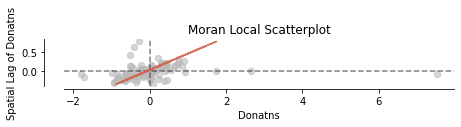

In [31]:
from splot.esda import moran_scatterplot
from esda.moran import Moran_Local

# calculate Moran_Local and plot
moran_loc = Moran_Local(y, w)
fig, ax = moran_scatterplot(moran_loc)
ax.set_xlabel('Donatns')
ax.set_ylabel('Spatial Lag of Donatns')
plt.show()

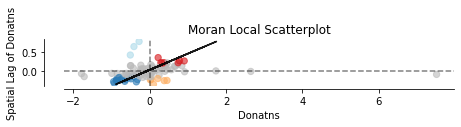

In [32]:
fig, ax = moran_scatterplot(moran_loc, p=0.1)
ax.set_xlabel('Donatns')
ax.set_ylabel('Spatial Lag of Donatns')
plt.show()

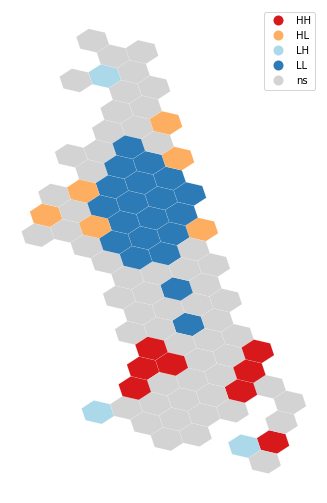

In [33]:
from splot.esda import lisa_cluster
moran_loc = Moran_Local(y, w)
lisa_cluster(moran_loc, df_duration, p=0.1, figsize = (9,9))
plt.show()

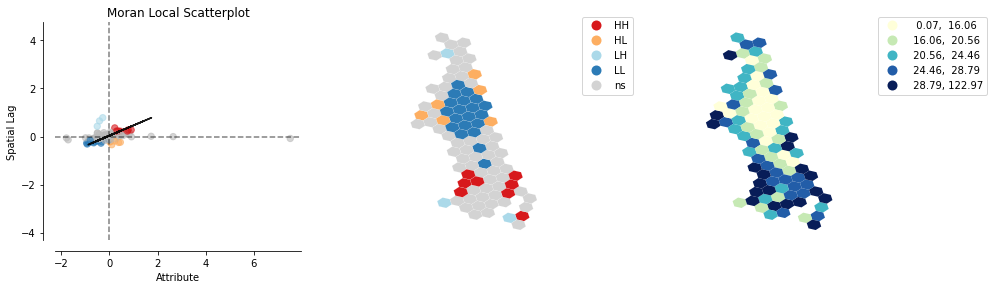

In [34]:
from splot.esda import plot_local_autocorrelation
plot_local_autocorrelation(moran_loc, df_duration, 'median_duration_minutes', p=0.1)
plt.show()